In [1]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_l = pd.read_csv('data/listings.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
counts = df_l.groupby('neighbourhood_cleansed', as_index = False)['id'].count()

In [4]:
counts['ratio'] = counts['id'] /  df_l.shape[0]

In [5]:
counts.columns = ['neighbourhood', 'count', 'ratio']

In [6]:
import geopandas as gpd
df_geo = gpd.read_file('data/neighbourhoods.geojson')

In [7]:
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt

In [8]:
df_geo = df_geo.merge(counts, on = 'neighbourhood', how= 'left')

In [30]:
df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.centroid)

In [32]:
points_df = df_geo[['neighbourhood', 'coords']]

In [36]:
points_df.columns = ['name', 'geometry']
df_p = gpd.GeoDataFrame(points_df)

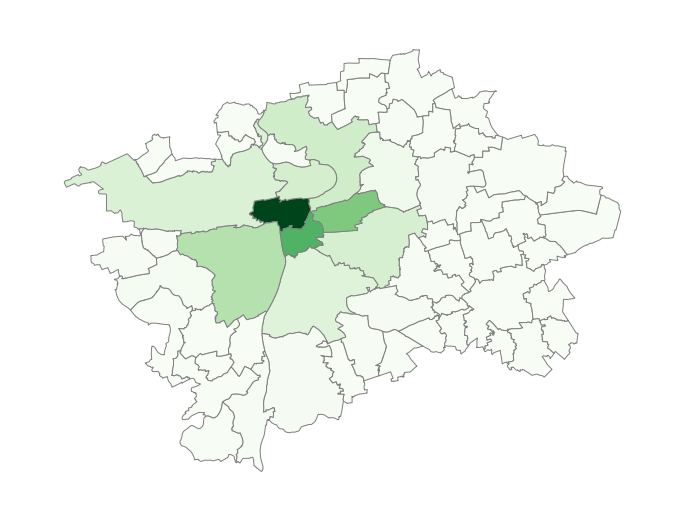

In [64]:
ax = gplt.choropleth(df_geo, 
                     projection=gcrs.AlbersEqualArea(),
                     hue = df_geo['ratio'],
                     cmap = 'Greens',
                     edgecolor='grey', linewidth=1,
                     figsize=(12, 12))

In [95]:
points = gpd.GeoDataFrame(
    df_l, geometry=gpd.points_from_xy(df_l.longitude, df_l.latitude))

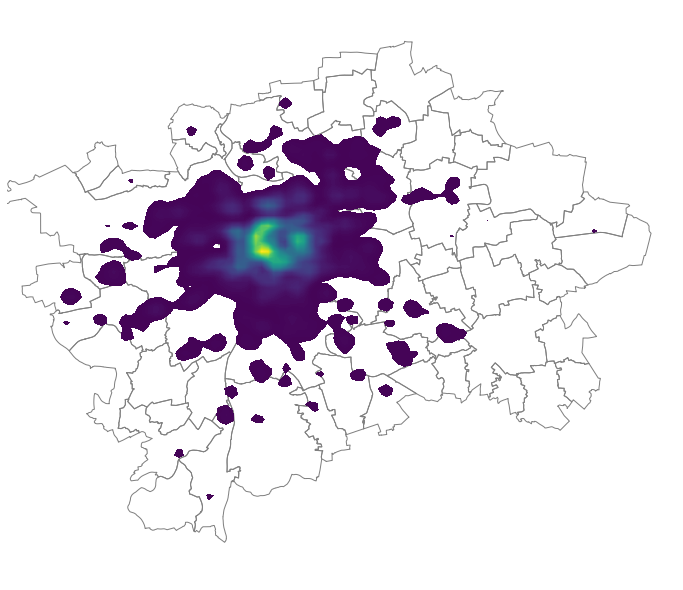

In [119]:
ax = gplt.polyplot(df_geo, 
                     projection=gcrs.AlbersEqualArea(),
                     edgecolor='grey', linewidth=1, figsize=(12, 12))

gplt.kdeplot(points, shade = True, n_levels=200, projection=gcrs.AlbersEqualArea(), ax = ax)